1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

За основу взят код из методички.

Критерии останова реализованы в функции build_tree

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

Функция для создания бутстрепированных подвыборок

In [2]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = int(labels[sample_index])         
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

Функция рандомного выбора признаков для построения отдельного дерева в лесу (кол-во признаков равно корню из количества признаков в изначальном датасете)

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

Функция расчета индекса Джини

In [6]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
#создаем функцию подсчета  энтропии
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * np.log2(p)
    impurity = (-1) * impurity
    return impurity

In [9]:
# добавляем в функцию подсчета функционала качества новый аргумент quality_criteria, чтобы его можно было определять при вызове функции
def quality(left_labels, right_labels, current_criteria_value, quality_criteria=entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criteria_value - p * quality_criteria(left_labels) - (1 - p) * quality_criteria(right_labels)

In [10]:
# добавляем аргумент quality_criteria и в эту функцию
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_levels, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy, current_level=0):
    quality, t, index = find_best_split(data, labels, min_in_leaf, quality_criteria)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #if quality == 0:
    #    return Leaf(data, labels)

    if quality <= min_quality_gain:
        #print(f'quality={quality} on level {current_level} for feature index={index} with t={t} is less than min_quality_gain - make a Leaf here')
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    current_level += 1

    if current_level == max_levels:
        return Leaf(data, labels)   
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_levels, min_in_leaf, min_quality_gain=min_quality_gain,quality_criteria=quality_criteria, current_level=current_level)
    false_branch = build_tree(false_data, false_labels, max_levels, min_in_leaf,  min_quality_gain=min_quality_gain,quality_criteria=quality_criteria, current_level=current_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# добавляем аргумент quality_criteria и в эту функцию
def find_best_split(data, labels, min_in_leaf=1, quality_criteria=entropy):    
    
    current_criteria_value = quality_criteria(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]

    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_in_leaf or len(false_data) < min_in_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criteria_value, quality_criteria)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
#функция, возвращающая лес из n_trees обученных деревьев
def random_forest(data, labels, n_trees, max_levels=10, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, max_levels, min_in_leaf, min_quality_gain, quality_criteria))

    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [16]:
# сгенерируем данные, представляющие собой 1000 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=2, random_state=23)

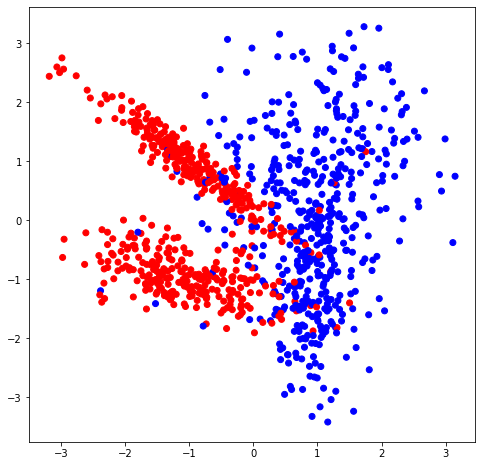

In [17]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [24]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [19]:
  # Введем функцию подсчета точности как доли правильных ответов
  def accuracy_metric(actual, predicted):
      correct = 0
      for i in range(len(actual)):
          if actual[i] == predicted[i]:
              correct += 1
      return correct / float(len(actual)) * 100.0

 Случайный лес из 1 дерева

In [20]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [25]:
# предсказания на обучающей выборке
answer = tree_vote(my_forest_1, train_data)

In [30]:
train_accuracy = accuracy_metric(train_labels, answer)
train_accuracy

94.85714285714286

In [31]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_1, test_data)

In [32]:
# accuracy предсказаний на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
test_accuracy

86.66666666666667

Text(0.5, 1.0, 'Test accuracy=86.67')

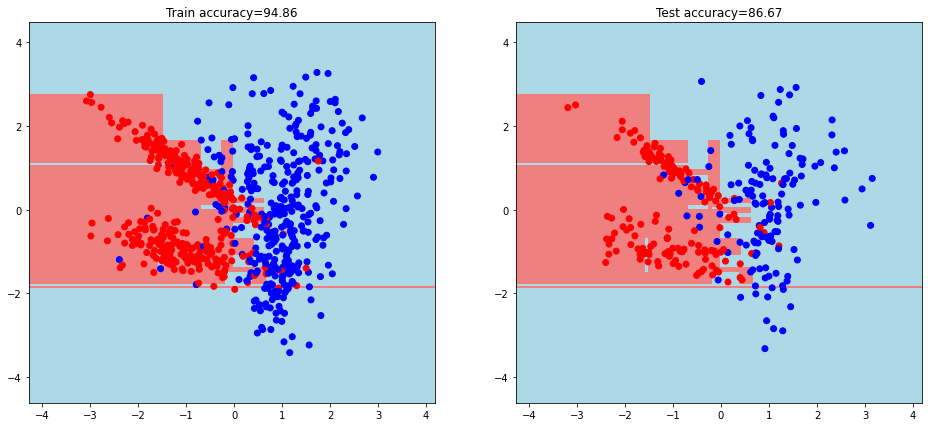

In [33]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 3-х деревьев

In [34]:
n_trees = 3
my_forest_2 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [35]:
# предсказания на обучающей выборке
train_answer = tree_vote(my_forest_2, train_data)

In [36]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_2, test_data)

In [37]:
# accuracy предсказаний на обучающей выборке
accuracy_metric(train_labels, train_answer)

97.28571428571429

In [38]:
# accuracy предсказаний на тестовой выборке
accuracy_metric(test_labels, test_answer)

88.66666666666667

Text(0.5, 1.0, 'Test accuracy=86.67')

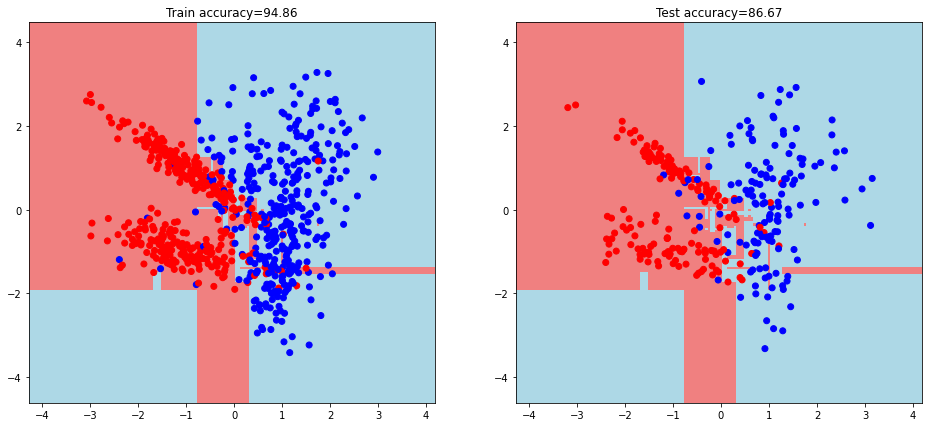

In [40]:
# Визуализируем лес на графике

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_2, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 10-ти деревьев

In [41]:
n_trees = 10
my_forest_3 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [42]:
# предсказания на обучающей выборке
train_answer = tree_vote(my_forest_3, train_data)

In [43]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_3, test_data)

In [44]:
# accuracy предсказаний на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answer)
train_accuracy

99.57142857142857

In [45]:
# accuracy предсказаний на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
test_accuracy

90.33333333333333

Text(0.5, 1.0, 'Test accuracy=90.33')

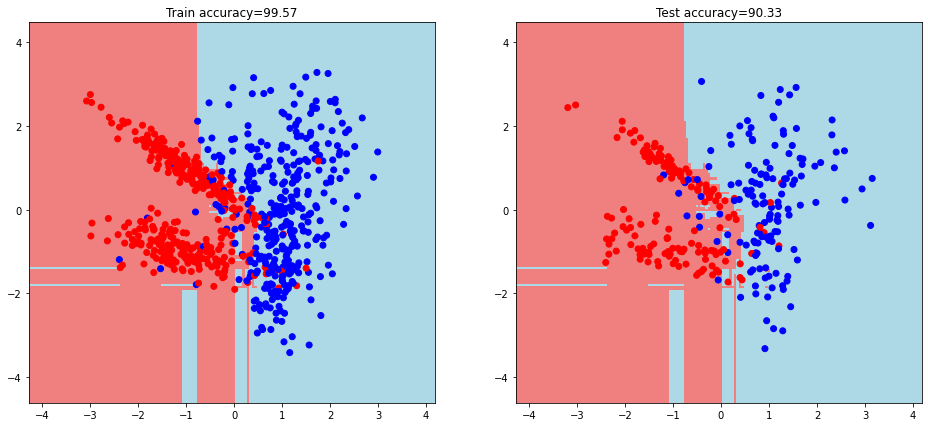

In [47]:
# Визуализируем лес на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 50-ти деревьев

In [48]:
n_trees = 50
my_forest_4 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [49]:
# предсказания на обучающей выборке
train_answer = tree_vote(my_forest_4, train_data)

In [50]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_4, test_data)

In [51]:
# accuracy предсказаний на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answer)
train_accuracy

100.0

In [52]:
# accuracy предсказаний на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
test_accuracy

90.0

Text(0.5, 1.0, 'Test accuracy=90.00')

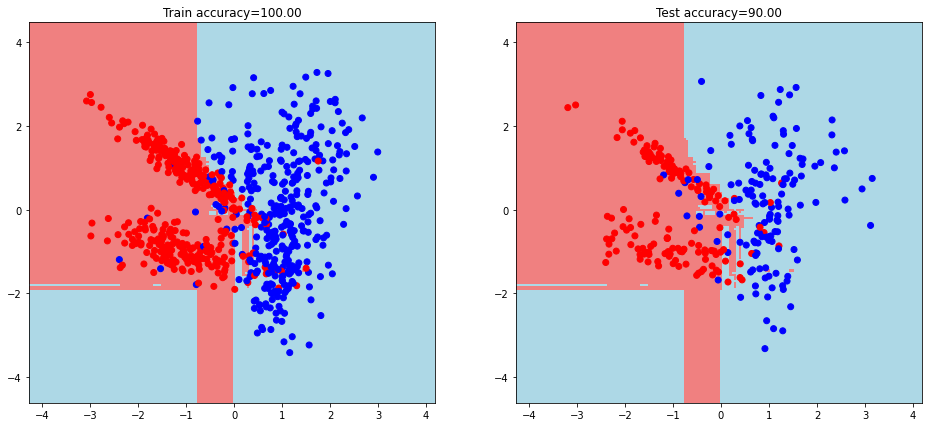

In [53]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_4, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 100 деревьев

In [54]:
n_trees = 100
my_forest_5 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [55]:
# предсказания на обучающей выборке
train_answer = tree_vote(my_forest_5, train_data)

In [56]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_5, test_data)

In [57]:
# accuracy предсказаний на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answer)
train_accuracy

100.0

In [58]:
# accuracy предсказаний на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
test_accuracy

90.0

Text(0.5, 1.0, 'Test accuracy=90.00')

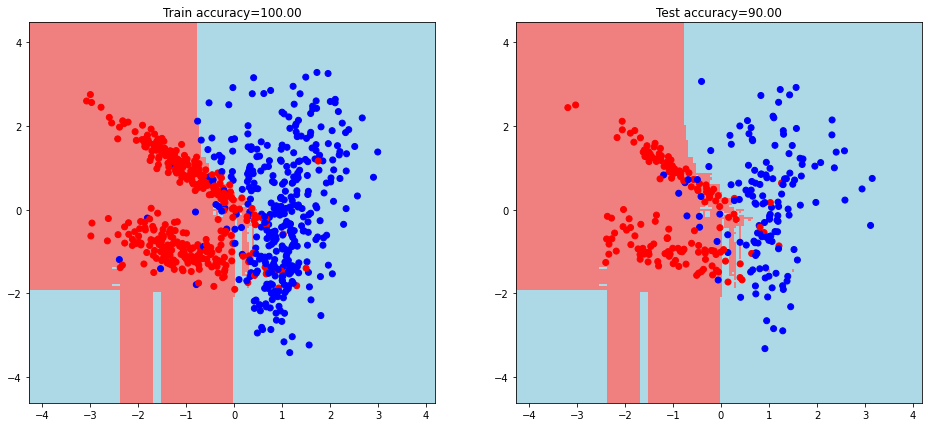

In [59]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_5, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 200 деревьев

In [60]:
n_trees = 200
my_forest_6 = random_forest(train_data, train_labels, n_trees, max_levels=20, min_in_leaf=1, min_quality_gain=0, quality_criteria=entropy)

In [61]:
# предсказания на обучающей выборке
train_answer = tree_vote(my_forest_6, train_data)

In [62]:
# предсказания на тестовой выборке
test_answer = tree_vote(my_forest_6, test_data)

In [63]:
# accuracy предсказаний на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answer)
train_accuracy

100.0

In [65]:
# accuracy предсказаний на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
test_accuracy

89.33333333333333

Text(0.5, 1.0, 'Test accuracy=89.33')

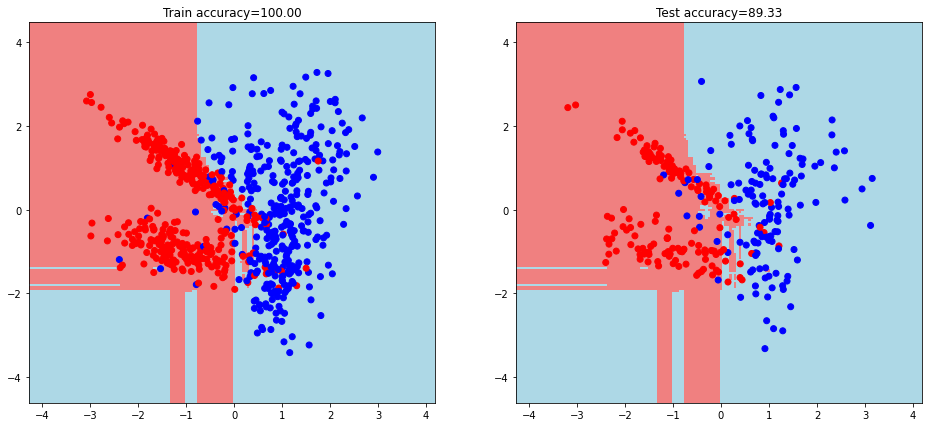

In [66]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_6, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

С ростом количества деревьев в лесу разделяющие плоскости становятся более обобщающими и простыми. При небольшом количестве деревьев в случайном лесу имеет место значительное переобучение. С ростом коичества деревьев переобучение снижается, но с какого-то момена выходит на плато (без использования дополнительных гиперпараметров, снижающих переобучение).

2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

К сожалению на опциональное задание не было времени